# **Project 2 - Genetic Algorithm for Image Reconstruction.**
**Subject:** MC906/MO416 - Introduction to Artificial Intelligence 

**Authors:**

    Eduardo Barros Innarelli - RA 170161
    Victor Ferreira Ferrari  - RA 187890
    Vinicius Couto Espindola - RA 188115

## **Introduction**
### Project
The project consists of a study of genetic algorithm-based solutions for **image reconstruction**. A few set aspects of the problem will be explained, implemented and discussed here, such as:

- The **modeling** of the problem as an evolutionary problem (chromosomes, genes, etc);
- How to **generate the initial population**;
- The chosen **fitness function**;
- How to **visualize** the result.

Along with that, some aspects of the genetic algorithm will be tested and discussed with multiple approaches, such as:

- Stop criteria;
- Selection technique;
- Crossover technique;
- Mutation technique;
- Generation replacement method.

Also, the following **parameters** will be tested with multiple values as well:
- Population size;
- Mutation rate;
- Crossover rate.

In the end, different variations of the process will be compared and discussed.

### Usage

This project uses the external libraries _OpenCV_ for image reading and manipulation, _NumPy_ for array manipulation, and _MatPlotLib_ for result visualization. The other imports are part of the Standard Python Library.

In [45]:
# External Libraries
from matplotlib import pyplot as plt
from cv2 import imread, imwrite, resize
import numpy as np

# Python Libraries
from time import time
from itertools import combinations
from random import sample, choices, shuffle
from os.path import join, basename

# IPython Libraries
from IPython.display import Image, display

## **Problem**
### General Information
The problem consists of, given the original image, recreating an image from scratch. The original is only used for fitness purposes (how good is the image generated). This is not particularly useful in many applications, but can be used as basis for other problems, and is good for the purpose of this project: test different methods of reproduction, mutation, etc.

The motivation came from [Roger Johansson's "Evolution of Mona Lisa"](https://rogerjohansson.blog/2008/12/07/genetic-programming-evolution-of-mona-lisa/), but instead of using polygons, the pixel values are directly used.

### Modeling
The modeling of the problem as a GA problem is almost direct: the image is the individual (chromosome) and each of its pixels is a gene. The image can be represented by a multitude of different ways. The chosen way of representation is as a flat array, as this allows for easier operations, especially crossover.

### Inputs
Due to the huge number of combinations in a regular RGB image ($255^3$ possiblities per pixel), greyscale images are used in this project. High resolution images were rescaled to a lower resolution using *OpenCV* as some images would simply take too long to test.

## **Methods**

### Notes on Structure

The code was organized in such a manner which allows us to first define every method used as well as discuss them in separated modules, making each part more readable and comprehesible.

In order to merge all components of the code, we created a class called GeneticAlgorithm. This class retains some essential variables for the methods defined along the report. To allow such methods to access these variables (even though they are not a part of the class) nearly every method must receive as it's **first parameter the class instance** which is referred as the **parameter 'self' in the method's definitions**. It should also be noted that the method usualy have no return statements, simply because the 'self' parameter is a reference to the class instance, which **allow the methods to make changes in-place**.

To specify which class variables are necessary/used and which are defined/altered by the methods in each section, there will be a list of **used class variables** and **defined class variables** within the description of every section. On top of these uses and definitions, there are parameters which are method dependent, these are in the sections **necessary parameters**.

### The Goal Image

Before starting the algorithm we must first read an image from memory. To do so we'll use the read function embedded in the GeneticAlgorithm class. This function is responsible for reading the image, reducing it's resolution, flattening it to an array and finally storing it in the class.

The read image is kept in two class variables: 
 1. *self.goal* - The flattened image, which is an array containing the input image pixels. 
 2. *self.shape* - After dowscalling and before flattening the image, we must save the input image shape so we can reverse the flattening process allowing us to visualize the array of genes as an image.
 
**Note:** a relevant detais is that the length of the array kept in *self.goal* is the amount of genes every individual must have, so we'll often use the variable *self.goal.size* to set the amount of genes in methods were this information is necessary.

Since processing the input image is the first step of the algorithm, the methods defined bellow this section will consider that the class variables *self.goal* and *self.shape* are defined and ready to be used.

### Population Initialization
**Responsible: Vinícius (Major) and Victor (Minor)**

The first step to run a genetic algorithm is creating a population to serve as a starting point for the selection, reproduction and mutation process. 

**Necessary parameters:**
 1. *pop_size* - Defines the amount of individuals to be created in the initial population.

**Used class variables:** 
 1. *self.goal.size* - Defines the amount of genes that every individual must have.

**Defined class variables:**
 1. *self.population* - List of *ndarrays* where each element contains the genes of an individual.
 2. *self.all_fits* - List of float values where each element is the fitness of an individual.
 3. *self.pop_size* - Saves the value chosen for population size (*pop_size* parameter).

The following code defines some methods which will be used to create a population out of nothing.

#### Random Initialization
The first method chosen for this stage was the completely random initialization. Here we simply randomize every gene of the *pop_size* individuals considering the possible state space, in other words, we generate *pop_size* arrays by randomizing every of it's *self.goal.size* elements within the range $[0-255]$.  

In [2]:
def random(self, pop_size):
    # Generate completely random indivuduals 
    self.population = []
    size = self.goal.size
    
    for i in range(pop_size):
        print(f"Generating Population...  {i:>3}/{pop_size}\r", end='')
        person = np.random.randint(0, 256, size, dtype=np.uint8)
        self.population.append(person)
    self.pop_size = pop_size
    print(f"{' '*50}\r", end='')

#### Partially Random Initialization

The complete random initilization isn't very helpful to provide a good starting point for the algorithm, allowing the initial population to be completely unfit when compared to the goal image. An alternative would be to insert one completely white individual with the others. This way, depending on the goal image, this individual can start better fit than the others.

This method does not ensure a better starting point for all images, though. For some images, as can be seen in the "Result" section, this white individual can make the entire population have a white section, over time. If, in the goal image, this section is not white, the algorithm depends on mutation to insert different values in that section.

In [3]:
def white_and_random(self, pop_size):
    self.population = []
    size = self.goal.size
    
    person = np.full(size, 255, dtype=np.uint8)
    self.population.append(person)
    
    for i in range(pop_size-1):
        print(f"Generating Population...  {i+1:>3}/{pop_size}\r", end='')
        person = np.random.randint(0, 256, size, dtype=np.uint8)
        self.population.append(person)
    self.pop_size = pop_size
    print(f"{' '*50}\r", end='')

### Fitness Function
**Responsible: Victor**

For each individual, we must determine a method which will tell us how apt such individual for the problem in question.

The MSE (mean squared error) is a very common error function for AI and Machine Learning models, so that was implemented here. Since we want more distance between the individuals when the error is low enough, we can use the squared error directly, without taking the mean. This makes for a big number, and more distance between individuals.

Finally, a "correct pixels" fitness function was made, to identify how many pixels are exactly the same as the goal image. This can be useful because it doesn't allow for much approximation, relying on directly imitating the goal image.

In [4]:
def squared_error(individual, original):
     return ((original.astype(np.float64) - individual.astype(np.float64))**2).sum()

In [5]:
def mse(individual, original):
     return squared_error(individual,original)/individual.size

In [6]:
def correct_pixels(individual, original):
    return np.count_nonzero(original.astype(np.int16) - individual.astype(np.int16))

### Convergence Criteria
**Responsible: Vinícius**

The algorithm cannot run forever. In this section will define a convergence method for halting the program's exection. 

The convergence function must identify when the algorithm's improvement rate has significantly decreased or even stalled. To do so, it must know to some extent the rate of improvement per generation, which can be infered by the difficulty of improving the best individual found so far. Assume we have the best indivudual so far ($B$), therefore, we can estimate when the algorithm is decreasing it's evolution rate (or improvement rate) by checking how many generations have passed since $B$ was achieved: the more generations where $B$ wasn't improved, the more likely is that the algorithm has converged. The convergence method defined in this section is based on this idea.

The convergence method will also play a secondary role: it is responsible for updating the best individual found across all generations, such individual is used as the final generated image which will be compared with the goal image.

**Necessary parameters:**
 1. *limit* - Suppose generation $X$ has the best individual so far, also suppose we are at generation $Y|Y>X$. This implies that the last $L=Y-X$ generation(s) did not improve the fittest individual found so far. If $L>limit$ we consider that the algorithm has converged.

**Used class variables:** 
 1. *self.all_fits* - Used to find the fittest individual of the new generation by getting the minimum fitness.
 2. *self.best_fit* - Holds the fittness of the best individual across all previous generations.

**Defined class variables:**
 1. *self.counter* - Counts generations since the last improvement of the best individual.
 2. *self.best_genfit* - If theres a new better individual we must update this variable.

#### Convergence Halting Method

In [7]:
def convergence(self, limit):
    ''' Identifies convergence and updates fittest individual found so far 
        
        Parameters:
            self - GeneticAlgorithm class which the function is being called from
            limit - Amount of iterations wich can be worst than the best one found so far
        Return:
            Bool - True if converged, False otherwise.
    '''
    # Get min fitness for population
    new_genfit = self.all_fits.min()
     
    # Update number of iterations without improvement
    if new_genfit >= self.best_genfit:
        self.counter += 1
    else:
        self.counter = 0
        self.best_genfit = new_genfit
    
    # Check convergence
    if self.counter >= limit or self.best_genfit <= 0:
        self.counter = 0
        return True
    else:
        return False 

#### Secondary Halting Method 

Even checking for convergence, the algorithm might still present sufficiently small improvements to avoid convergence, however, they might be so small that it will take a enormous amount of time to converge. As a failsafe to this scenario, we will limit the total amount of generations that can be created. This secondary halting method is not defined in this section however, it is defined withing the GeneticAlgorithm class as *self.abort()*.

### Parents Selection
**Responsible: Vinícius and Victor**

In this section we'll define methods responsible for selecting from the population individuals responsible for bearing the next generation. The main goal is to find a method which properly balances the diversity and quality of the new generation of individuals.

An analysis of the fitness values showed that the individuals tend to have similar fit in the model we created, leading to premature convergence. This can affect methods such as *roulette selection* which depend heavily on the difference between the fitness score of individuals. A possible solution to this was to apply exponential transfer on the fitness values of the individuals so one does not monopolize the probability, which could lead to homogenization. Another solution to prevent this issue was to implement methods which depend on the comparison among a group of individuals chosen with equal probability. An example of such method is the *tournament selection*.  

**Necessary parameters:**
 1. *N* - The amount of individuals which will be selected for reproduction.
 2. *k* - Defines the amount of competiors in each tournament (tournament selection only).
 3. *P* - Defines how many partners an individual can have (tournament selecion only).
 4. *T* - Defines the maximum amount of couples allowed (tournament selection only).
 
**Used class variables:** 
 1. *self.pop_size:* Used to define the range of the individuals indexes within the population.
 2. *self.all_fits:* The selection is based on the individuals fitness, therefore this variable is accessed.
 
**Defined class variables:**
 1. *self.mates:* creates a list of tuples where each tuple pairs the index of two individuals for reproduction.
 
The following code defines some methods which will be used to select individual for the creation of the next generation.

#### Tournament Selection

Suppose we're given a population $P$. The tournament method will randomly select $k$ individuals out of $P$, then the fittest individual out of the $K$ selected will be chosen to partake in the reproduction step. This process is repeated until we have selected $N$ winners.
The second step is pairing the $N$ winners among themselves creating couples. This step is done by first creating every two number combination possible with the $N$ elements and then applying restrictions over which pairs from the combination will be a valid couple. 

Suppose we have an element $x\in N$:
 1. *$x$ will never form a couple with itself* - A child of the couple $(x,x)$ would simply produce $x$.
 2. *$x$ will only match with some $y \in N$ exactly once* - Repeating couples such as $(x,y)$ and $(y,x)$ is likely to reduce the population's diversity.
 3. *$x$ can be in at most $P$ of the selected couples* - If an element $x$ partakes in multiple couples, diversity is likely to deteriorate.

The couples will be matched using elements from $N$ and obeying the previous restrictions, we can pick at most $T$ pairs.

In this method the size of $K$ controls diversity: when $K$ is larger, it's more likely that unfit individuals are competing with fitter ones, therefore there will likely be a smaller diversity within the population. If we seek more diversity, a smaller $k$ might help. 


In [8]:
def tournament(self, k, N, P, T):
    pool = list(range(self.pop_size))
    pairs = {x:set() for x in pool}
    fitness = lambda x: self.all_fits[x]
    winners,self.mates = [],[]

    # Run tournament to pick N winners
    while len(winners) < N:
        competitors = np.random.choice(pool, size=k, replace=False)
        winner = max(competitors, key=fitness)
        winners.append(winner)
        pool.remove(winner) # remove winner from pool
    
    # Combination: given a pool of winners, match them as couples
    for (dad,mom) in shuffle(combinations(winners, 2)):
        if (len(pairs[dad]) < P) and (len(pairs[mom]) < P): 
            pairs[dad].add(mom)
            pairs[mom].add(dad)
            self.mates.append((dad,mom))
            if len(self.mates) == T: break

#### Roulette Method

Suppose we're given a population $P$. The roulette method will attribute a probability for each individual according to it's fitness value: lower fits implies high probability and higher fits implies lower probabilities. This allows a stochastic method to prize the quality individual without losing too much diversity, especially since _exponential transfer_ is used as a method to avoid premature convergence.

In contrast with the tournament method, the roulette does not discriminate individuals. For that reason, any individual can be matched with any other individual, including with itself, and the same match can happen multiple times. That is why a way to avoid premature convergence is needed.

In [9]:
def roulette(self, N):
    fit = self.all_fits
    size = self.pop_size
    
    # Exponential transfer.
    fit = np.sqrt(fit+1)
    
    # Roulette method: select N individuals from the population,
    # with proportional probabilities to their fitness values.
    probs = fit/fit.sum()
    probs = (1-probs)/(size-1)
    winners = np.random.choice(np.arange(size), size=N, replace=True, p=probs)    
    
    self.mates = list(zip(winners[::2],winners[1::2]))

### Crossover Techniques
**Responsible: Eduardo and Victor**

In this section we'll define methods that generate descendants from selected parents. 

Based on genetic recombination, crossover exchanges genes between two individuals in a stochastic manner, resulting in a new one. Computationally, the way genes are swapped depends on the method implemented. By reproducting, the population preserves genetic diversity between generations.

**Necessary parameters:**
 1. *K* - Determines the ammount of points to use when applying k-point crossover.
 2. *Window* - Tuple with the size of the window for the crossover (block crossover only).
 
**Used class variables:** 
 1. *self.goal.size* - This attribute tells us how many genes are there in a individual.
 1. *self.mates* - Each couple in this variable will be parents in the reproduction method.
 
**Defined class variables:**
 1. *self.children* - These are the new individuals generated from reproduction.

#### K-Point Crossover Reproduction

Supose we're given two individuals $A$ and $B$. This method will split the individual genes in $K$ points and exchagen the resulting sections of genes. The algorithm is quite simple: get the amount of genes $G$, select $K$ points within the range $[0-G]$ then swap the genes among parents within the ranges define by the range and the $K$ points.

In [10]:
def k_point_crossover(self, k):
    ''' 
    For each couple, K points are picked randomly from their chromossomes and
    genes between these points are swapped, intercalating pairs of points.
    
    Parameters:
        self - GeneticAlgorithm class which the function is being called from
        k - Amount of crossover points for gene exchange
    '''
    
    num_genes = self.goal.size
    self.children = []

    for father, mother in self.mates:
        # Save k unique random crosspoints in a sorted list
        crosspoints = sorted(sample(range(0, num_genes-1), k))
        
        # Deep copy to freely change values
        father = self.population[father].copy()
        mother = self.population[mother].copy()
        
        # List of crosspoint pairs, adding a pair with last crosspoint
        # and last pixel
        # Ex: 
        # 16 pixels, points [1,9,12] -> pairs [(1,9), (9,12), (12,16)]
        pairs = list(zip(crosspoints,crosspoints[1:]))
        pairs.append(tuple((crosspoints[-1], num_genes)))

        # Perform crossover in pair range, intercalating pairs
        for start, end in pairs[::2]:
            father[start:end], mother[start:end] = mother[start:end], father[start:end]
        
        self.children += [father, mother]

#### Block Crossover Reproduction

As mentioned previously, the individuals are represented by a flattened version, in an 1D array. However, it is still an image, and the best representation is as a 2D array, because a pixel usually is related to the one above or below, and not only the ones in the same row.

For that reason, crossover by blocks or windows, instead of rows, can be more effective in minimizing fitness. The following method crosses over random windows of fixed sizes between pairs.

In [11]:
def block_crossover(self, window):
    self.children = []
    
    for father, mother in self.mates:
        father = self.population[father].copy()
        father.reshape(self.shape)
        mother = self.population[mother].copy()
        mother.reshape(self.shape)
        
        start_lin = np.random.randint(0, self.shape[0]-window[0])
        start_col = np.random.randint(0, self.shape[1]-window[1])
        
        idx = []
        for i in range(window[0]):
            fun = lambda x: (start_lin+i, start_col+x)
            idx += [fun(x) for x in range(window[1])]

        father[idx],mother[idx] = mother[idx],father[idx]
        self.children += [father.ravel(), mother.ravel()]

### Mutation Method
**Responsible: Victor**

Just permuting the genes of the previous generation might reduce the diversity among individuals by creating childs which are too similar to their parents. To counter this we'll use mutation methods allowing genes to mix within individuals.

The core idea of mutation methods are to affect some genes of some individuals with some unpredictable alteration. This granular insertion of randomness can revive diversity in a homogeneous population without causing the quality of individuals to deteriorate (which would conflict with the selection and reproduction steps). There are two core values to ensure the granularity of these changes: the *Mutation Rate* defines a percentage of individuals which will mutate, and the *Mutation Amount* defines the percentage of genes which will mutate per individual.

**Necessary parameters:**
 1. *MR* - Mutation rate dictates the probability of an individual to mutate.
 2. *MA* - Mutation amount defines the amount of genes which will mutate.
 
**Used class variables:** 
 1. *self.goal.size* - This attribute tells us how many genes are there in a individual.
 1. *self.children* - Mutations are applied only on the individuals resulting from the reproduction step.
 
**Defined class variables:**
 1. *self.children* - The childrens gene are altered in-place altering this value.

The following code defines some methods which will be used to mutate the individuals.

#### Random Mutation

Given a population $P$ where each individual has $G$ genes, randomly pick $MR\cdot |P|$ individuals and for each of these individuals randomly pick $M\cdot |G|$ genes to ramdomize within the range $[0-255]$. Quite straightforward.

In [12]:
def random_mut(self, MR, MA):
    # Set some synonyms
    size = self.goal.size
    pop  = self.children
    
    # Select individuals to mutate.
    mut_amount = int(MR*len(pop)) # amount of individuals to mutate
    individuals = choices(pop, k=mut_amount)
    
    # Change elements to random value.
    gene_amount = int(MA*size) # amount of genes to mutate per individual
    for i in individuals:
        genes = np.random.choice(size, gene_amount, replace=False)
        new   = np.random.randint(0, 256, gene_amount, np.uint8)
        i[genes] = new # Changes are in-place

#### Reduced Mutation

This method is quite similar to the previous, still picking the same amount of individuals and genes randomly, but this time exploring a property of images. Small variations on pixels are visible, but a somewhat different shade can still result in a similar image. Therefore, we can restrict the amount of shades the mutated genes can receive, in the interest of getting a "good enough" approximation instead of the same exact image as the goal.

In [13]:
def reduced_mut(self, MR, MA):
    # Set some synonyms
    size = self.goal.size
    pop  = self.children
    
    # Select individuals to mutate.
    mut_amount = int(MR*len(pop)) # amount of individuals to mutate
    individuals = choices(pop, k=mut_amount)
    
    # Change elements to random value.
    gene_amount = int(MA*size) # amount of genes to mutate per individual
    for i in individuals:
        genes = np.random.choice(size, gene_amount, replace=False)
        new   = np.random.randint(0, 32, gene_amount, np.uint8)
        i[genes] = new*8 # Changes are in-place

#### Increment Mutation

We'll repeat most of the steps from the previous method, however we'll also constraint how much each gene can mutate based on the original value of the gene. Suppose we will mutate some gene $g$, when doing so this mutation will be constrained to be within some range $[g-\epsilon,g+\epsilon]$. The main goal of this method is to have a even more fine control of the mutation. In this case, $\epsilon$ is not a parameter, but a constant $\epsilon=10$.

In [14]:
def inc_mut(self, MR, MA):
    # Set some synonyms
    size = self.goal.size
    pop  = self.children
    
    # Select individuals to mutate.
    mut_amount = int(MR*len(pop)) # amount of individuals to mutate
    individuals = choices(pop, k=mut_amount)
    
    # Change elements to random value.
    gene_amount = int(MA*size) # amount of genes to mutate per individual
    for i in individuals:
        genes = np.random.choice(size, gene_amount, replace=False)
        new   = np.random.randint(-10, 11, gene_amount, np.int8)
        i[genes] += new # Changes are in-place

### Replacement Techniques
**Responsible: Eduardo**

In this stage we're storing both the parents and their children. Increasing the population size can affect the algorithm performance in terms of memory usage and time as well as the convergence rate due to unfit individuals being kept alive. To mitigate this, it's necessary to choose which individuals will remain in the new generation.

**Necessary parameters:**
 - None.
 
**Used class variables:** 
 1. *self.children* - Calculates the fitness of every child to apply the replacement method.
 
**Defined class variables:**
 1. *self.all_fits* - Will be updated with the fitness of the individuals that survived the replacement.
 2. *self.population* - The population will also be updated with the individuals that survived the replacement. 

#### Elitism

The elitism replacement method follows the "survival of the fittest" principle, where the children are placed in the same pool as the previous generation, and the $N$ best individuals from that pool are chosen to survive. This speeds up convergence, since the population is always improving before converging.

In [15]:
def elitism(self):
    ''' 
    Preserve the fittest individuals between both parents and children
        
    Parameters:
        self - GeneticAlgorithm class which the function is being called from
    '''
    
    # Calculate children fitness.
    generator = map(lambda x: self.fit(x, self.goal), self.children)
    all_fits = np.concatenate((self.all_fits, np.array(list(generator), dtype=np.float64)))
    
    # Sort fits and population by fits.
    idxs = all_fits.argsort()
    full = self.population + self.children
    full = np.array(full)
    
    # Combine parents with children, sorted by fitness function
    combined = full[idxs]
    all_fits = all_fits[idxs]
    
    # Update population with the fittest individuals
    self.population = list(combined[:self.pop_size])
    self.all_fits = all_fits[:self.pop_size]

#### Steady State

The steady state replacement method ensures that all children generated in this generation are included in the next one. This means that, if $N$ children are created, this has the same effect as a generational replacement. If $M<N$, though, those $M$ children will replace the **least fit** parents.

This method is interesting because it gives incentive to diversity, since all children are included in the next generation, while still preserving the best from the previous generation.

In [16]:
def steady_state(self):
    ''' 
    Children replaces the least fit parents.
    
    Obs: if number of children and parents are equal, this has the same
    effect as a generational replacement.
    
    Parameters:
        self - GeneticAlgorithm class which the function is being called from
    '''
    
    pop_sorted = sorted(range(self.pop_size), key = lambda x: self.all_fits[x])
    
    # Replace worst fits from population with childs
    while self.children and pop_sorted:
        old = pop_sorted.pop()
        new = self.children.pop()
        self.population[old] = new
        self.all_fits[old] = self.fit(new, self.goal)

## **Genetic Algorithm Class**
**Responsible: Vinícius (Major) and Victor (Minor)**

The class will be responsible for selecting which methods will be used for the genetic algorithms steps as well as define it's parameters and executing the main loop. The main loop will be responsible for properly calling the methods and computing any in between tasks, as well as checking for halting conditions and picking the fittest individual found in all generations. This pattern was chosen as a way facilitate testing with different methods and parameters as well making the report modular.

##### Initialization Process

The initialization must receive the methods for each step (initialization, selection, reproduction, mutation and replacement), the fitness function to be used and the maximum amount of generations to be created. It's also responsible for defining the class variables which are shared among methods.

The functions used for each step of the algorithm have the following declaration: `f(self, x, y, ...)` and do not return any value. If we wish to use this function within the class we must pass both the function and it's parameters as a tuple in the initilization to the correct default arguments, which are: *limit*, *fit*, *conv*, *init*, *mating*, *crossover*, *mutate* and *replace*. 

Return values are not used in these methods, as all of them have access to the shared class variables in the parameter `self`, allowing changes directly to these class variables.

**Examples:** Suppose function `f(self, x, y, z)` is a reproduction method, therefore we will pass the default argument `crossover` as `crossover = (f,[x,y,z])`. Suppose function `h(self)` is a replacement method, therefore we will pass the default argument `replace` as `replace = (f,None)`.

This allows use to define multiple function for each step of the algorithm and select which one to use by simply changing the default argument passed in the GenericAlgorithm class initializations. We can also easily change parameters when testing.

##### Fitness Update Method

The `GeneticAlgorithm.update` method seeks to contain all necessary fitness update in a single function which is called only once per iteration. This is the most computationally expensive part of the algorithm, containing and calling it a single time per iteration is paramount for perfomance.

##### Main Loop

The `GeneticAlgorithm.test` function contains the main loop of the algorithm which is reponsible for coodinating the usage of each method defined for each step. The default parameter `graph` can be used to define datapointd for ploting the fitness values progression across generations. Whe can define `graph=list(range(100,5))` to collect data each 5 generations until we reach generation 100.

##### Preprocessing and Visualization Method

the `GeneticAlgorithm.read` method can read an image from a given path and downscale it accorgin to a value `res_factor`. The downscaling can be both a float value, which will alter the image resolution percentualy, or it can be a tuple of integers definig the amount of pixels in each dimension. This method also flattens the image making it into an one dimensional array, which is necessary for or model.

The `GeneticAlgorithm.show` simply restored the flattened image to it's previous shape and exhibits it using _matplotlib_.

##### Fitness Plotting Methods

If the variable `graph` is defined when runing the main loop, the values for the worst individual in the current generation, the median individual in the current generation and the best individual found so far will be collect and exhibited in a graph at the end of the program's excution.



In [17]:
class GeneticAlgorithm():
    ''' The GeneticAlgorithm class retains and coordinates all necessary variables and methods
        for the execution of the genetic algorithm created.
        It's initialization receives the methods which will compute each step of the algorithm
        as well as the parameters utilized by each of these methods. A limit integer is also
        define to halt the programs execution.
        
        Methods:
            run    - execute the genetic algorithm based on the instance variables/methods
            update - recalculate individuals fitness and updates best individual so far
            read   - read a image from file, rescale and flatten
            show   - reshape flattened image and exhibit with matplotlib
    '''
    
    def __init__(self, 
                 limit     = 10000, # Max amount of generations to create
                 fit       = None,  # Function to calculate individual fitness
                 conv      = None,  # Convergence function and parameters
                 init      = None,  # Population Initializer function and parameters
                 mating    = None,  # Population Selection function and parameters
                 crossover = None,  # Selected Indviduals Crossover function and parameters
                 mutate    = None,  # Selected Indviduals Mutation function and parameters
                 replace   = None,  # Choose which individuals are kept/replaced
                ):
        
        # Halting criterias
        self.counter = 0 # Convergence counter
        self.limit = limit
        self.abort = lambda: bool(self.gen_count >= self.limit)
        
        # Goal related variables
        self.shape = None # Holds original downsized image shape
        self.goal  = None # Holds an array with the ideal individual (goal image)
        
        # Convergence related variables
        self.best        = None         # Best individual obtained so far
        self.best_fit    = float('inf') # The fit score of the bets individual so far
        self.all_fits    = None         # List of each individual fitness
        self.best_gen    = None         # Best generation.
        self.best_genfit = float('inf')
        
        # Generation related variables
        self.pop_size   = None  # The amount of individuals kept per generation
        self.population = None  # List of individual of the current generation
        self.gen_count  = 1     # Current generation (first, second, ...)
        self.mates      = None  # Paired individuals which will reproduce
        self.children   = []
    
        # Static Genetic Methods Functions
        self.fit = fit
        define = lambda x: lambda: x[0](self,*x[1]) if x[1] else x[0](self)
        self.conv   = define(conv)
        self.init   = define(init)
        self.mating = define(mating)
        self.crossover = define(crossover)
        self.mutate = define(mutate)
        self.replace = define(replace)
        # TODO: MR needs to decrease with time to converge.
        
        # Auxiliar variables
        self.time = 0
        self.plot_points = []
        
        test = [self.conv,self.init,self.mating,self.crossover,self.mutate]
        test = all(map(bool, test))
        assert test, "There are undefined steps for the algorithm"
    
    def test(self, img_path, res_factor=None, graph=None):
        milestones = [1000, 10000, 50000, 100000, 200000, 500000, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000]
        self.time = time()
        self.read(img_path, res=res_factor)
        self.init()
        
        generator = map(lambda x: self.fit(x, self.goal), self.population)
        self.all_fits = np.array(list(generator), dtype=np.float64)
        
        while not (self.conv() or self.abort()):
            print(f"Current Generation: {self.gen_count:>7} (avg. fit: {self.all_fits.mean():>12.3f}). Current Best: {self.best_fit:>10} (gen {self.best_gen}).\r", end='')
            
            self.mating()     # Generate tuples indicating mating pairs
            self.crossover()  # Generate two childs for each couple
            self.mutate()     # Apply mutation on all individuals (old and new)
            self.replace()    # Select which individuals will be kept
            
            self.gen_count += 1
            self.update()
            
            if graph and self.gen_count in graph: 
                self.update_points()
            
            if self.gen_count in milestones:
                self.write(self.best, img_path)
            continue
        
        print(f"\nElapsed time: {(time()-self.time):.3f}")
        self.counter = 0
        self.show(self.best, compare=True)
        self.write(self.best, img_path)
        if len(self.plot_points) > 2: self.plot(graph)
        
    def update(self):
        ''' Updates the fitness of every individual in the population.
            Also updates the fittest individual found among all generations.
        '''
        # Update fittest individual
        idx = np.argmin(self.all_fits)
        if self.all_fits[idx] < self.best_fit: 
            self.best     = self.population[idx].copy() # save best inividual
            self.best_gen = self.gen_count
            self.best_fit = self.all_fits[idx]

    def update_points(self):
        idx = sorted(range(self.pop_size), key=lambda x:self.all_fits[x])
        best = self.best_fit
        med = self.all_fits[idx[self.pop_size//2]]
        worst = self.all_fits[idx[-1]]
        self.plot_points.append((best,med,worst))
        
    def plot(self, graph):
        x = graph[:len(self.plot_points)]
        y_best,y_med,y_worst = [],[],[]
        for b,m,w in self.plot_points:
            y_best.append(b)
            y_med.append(m)
            y_worst.append(w)
        plt.plot(x, y_worst, '--', label="Worst")
        plt.plot(x, y_med, '--', label="Median")
        plt.plot(x, y_best, 'r-',label="Best")
        plt.legend()
        plt.ylabel('Fitness')
        plt.xlabel('Generation')
        plt.title('Fitness per Generation')
        plt.show()
            
    def read(self, filepath, res=None):
        '''Reads an image in grey scale, resizes it and extends to array.
            Params:
                filepath - Path to the input image to be read
                res - Either tuple with new pixel dimensions or ratio with new scale
            Return: 
                np.array - array with the streched image
        '''
        img = imread(filepath,0) # load in greyscale
        
        if res and tuple==type(res):
            img = resize(img, res)
        elif res and float==type(res):
            w = int(img.shape[0]*res)
            h = int(img.shape[1]*res)
            img = resize(img, (h,w))
            
        self.shape = img.shape # keep shape
        self.goal  = img.reshape(img.size)

    def show(self, individual, compare=False):
        '''Prints the image represented by an individual.
            Params:
                individual - Np.array to be reshaped and printed
        '''
        plt.figure(figsize=(15,15))
        
        # If compare mode, print goal along side
        if compare: 
            plt.subplot(1,2,2)
            goal = self.goal.copy()
            goal = goal.reshape(self.shape)
            plt.imshow(goal, cmap='gray')
            plt.title('Goal')
            plt.axis('off')
            plt.subplot(1,2,1)
            
        img = individual.copy()
        img = img.reshape(self.shape)
        plt.imshow(img, cmap='gray')
        plt.title('Individual')
        plt.axis('off')
        plt.show() 
    
    def write(self, individual, path, folder='Outputs'):
        img = individual.copy()
        img = img.reshape(self.shape)
        name= 'g' + str(self.gen_count) + '_' + basename(path)
        imwrite(join(folder, name), img)

## **Tests**
**Responsible: Eduardo (Major), Victor (Minor) and Vinicius (Minor)**

Now that a few variations of each technique are implemented, it's possible to test multiple combinations of those methods and other parameters, and compare the final results.

### Test Cases

As previously mentioned, the test cases are **small**, **monochromatic** images, sometimes with a reduction factor. This is due to the amount of possibilities per individual, the convergence can be very slow if the pixel count is too large. Since we are dealing with a low pixel count, pixel art and sprites are good candidates for a recognizable goal image.

Along with those cases, some larger images (200x200) are also used to test scalability.

Current Generation:    5000 (avg. fit: 16996368.810). Current Best: 16969993.0 (gen 4998).
Elapsed time: 15.992


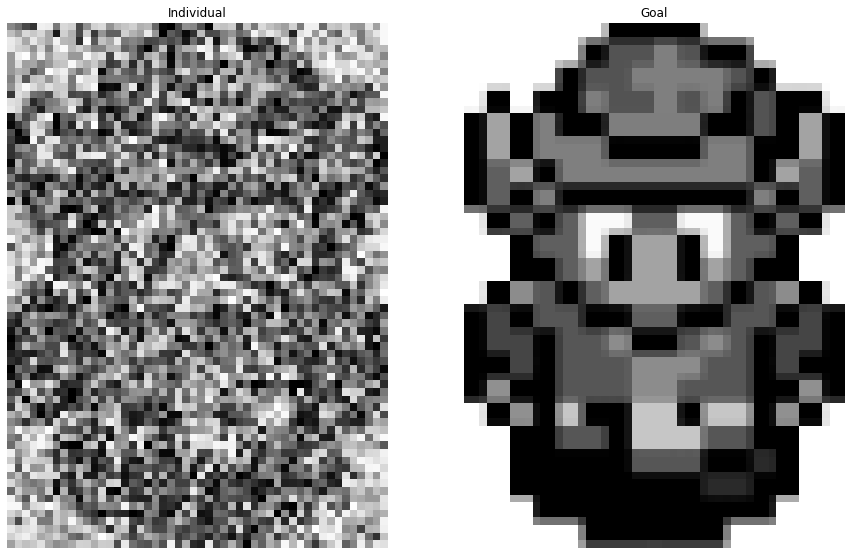

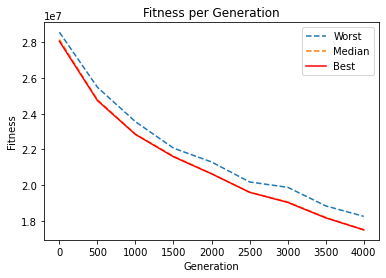

In [18]:
ga = GeneticAlgorithm(
    limit     = 5001,
    fit       = squared_error,
    conv      = (convergence,(10000,)), 
    init      = (white_and_random,(100,)),
    mating    = (roulette,[50]), 
    crossover = (k_point_crossover,[2]), 
    mutate    = (reduced_mut,[0.05,0.025]), # Tip higher MR and lower MA
    replace   = (steady_state,None),
    )

ga.test('images/link.png', res_factor=1, graph = list(range(1,5000,500)))

## **Notes on the Implementation Process**

 - A method of Uniform Crossover was implemented initially, to contrast with the k-point crossover. It was extremely slow since it had to iterate through every gene (and there are a lot of genes) and randomize the possibility of gene exchange. Despite being a possible counter measure to premature convergence, it was simply to slow to use.
 - Rergarding mutation rate and mutation ammount, in our case it appeared to be better when we would use the a higher probability of mutation with a smaller number of genes to mutate. The more genes we mutate, the slower is the iteration (as we need to roll the dice more times), so a higher change of mutation was a more efficient approach agains a higher number of genes to mutate.
 - Different sizes of populations did not seem to interfere significantly with the results, as expected a smaller population converges faster but it alsos converges prematurely most times.
 - We've noted that the elitism replacement method was killing the diversity within our population. This observation was done through the average fitness of each generation: with this value we were able to note that the average fitness was always equal to the best fit so far. So there was the need to wait for a mutation to insert some diversity in the population. Changing the the replacement method was helpful to create diversity and improve the convergence rate.

## **Comparisons**

### Method Comparison

### Parameter Comparison

## **Results and Analysis**

### Qualitative Analysis
Overall, the best results achieved for the small images were of good quality and high similarity. In some cases, it was possible to considerably reduce the fitness value to quite low values. Some of the final results and their original versions can be seen below. With the big images, it was possible to achieve results that resemble the original, with a lot of noise. In the image 'objetos.png', for example, the noise filled most of the white space in the picture, even (but less so) when a white image is used as starting point.

Two major problems that this project ran into were, in one hand, **premature convergence**, and on the other hand, **slow convergence speed**. Sometimes, both of these problems were present at once, when a lot of iterations were needed to keep optimizing the fitness value, and the convergence speed slowed down with still a high error value.

As noted previously, the first problem was made better by adding exponential transfer to the roulette selection. While that made the small images converge a lot better, the larger images still ended up with slowdowns after a few hundreds of thousands of iterations. The image was still improving regularly, but not as fast as needed to achieve the desired result, since the error was still in the tens of millions. This leads to the second problem. The balancing act brought the project to its current state.

A problem not related to convergence, however, is the slow iteration speed. This happens due to the amount of heavy operations in the code, such as the squared error and MSE calculations, and multiple instances of random number generation, be it with _NumPy_ arrays or regular lists. For these reasons, an iteration can be slow depending on the size of the input and the machine running the tests. The speed was improved with tweaks in different methods, avoiding repetition of calculations and using faster variations, but larger images still suffer with it. Since the larger images are also the ones that require more generations to converge, this becomes a big problem, which couldn't be solved so far, only improved.

With a good computer or using the Google Colab environment, it takes a few hours to run 5 million iterations on the larger images, with resolution reduction factor of 0.6. Since this problem wasn't solved so far, the best course of action is to avoid it, using higher reduction factors or smaller images. This also validates the decision to use greyscale images instead of RGB.

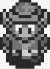

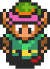

In [53]:
x=Image('Outputs/g2993857_link.png', width=150, height=150)
y=Image('images/link.png', width=150, height=150)
display(x,y)

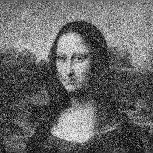

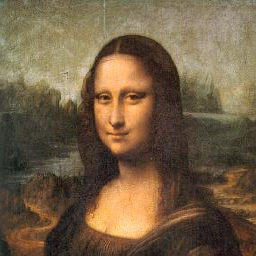

In [56]:
x=Image('Outputs/g4000000_monalisa.png', width=150, height=150)
y=Image('images/monalisa.png', width=150, height=150)
display(x,y)

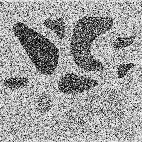

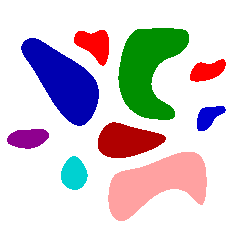

In [59]:
x=Image('Outputs/g271985_objetos_noisy.png', width=150, height=150)
y=Image('images/objetos.png', width=150, height=150)
display(x,y)

One interesting case to discuss is `objetos.png`. It is the second largest image to be used in this project. After reduction, the resulting image has 142x142 px dimensions, and the original has 238x238 px. The main difference with the content of this image is the amount of white space it contains, and the fact that it consists of 9 separated objects instead of a continuous figure.

The result above was obtained after 271985 generations, using the `random` initialization strategy. Notice how noisy the image is, in the white space and inside the objects. A noticeable characteristic is that the lighter objects are not as clear as the harder ones.

It is clear that the amount of noise in the white space is hurting the fidelity of the result, and that would have to be cleared at some point. When, instead, we insert a white image in the original population, using the `white_and_random` function, the result is quite different. The result with a similar amount of generations can be seen below.

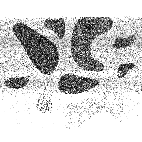

In [60]:
Image('Outputs/g200000_objetos.png', width=150, height=150)

That image, while still noisy, is much more clear than the one before, because the white image already starts with a lot of correct pixels. The noise is a result of collateral damage by mutation and over-crossover: the result is still a net positive from the full white. 

But a problem that might arise from this case is the homogenization of a part of the image. If every individual comes from the white board, it is possible that every image has the bottom half as just white, especially using the `elitism` replacement method, since crossovers in the upper half are more valuable than the bottom half in terms of optimization.

We can see that, while most noise is in the upper half, there are some shades of grey in the bottom half as well, so this could be due to the multi-point crossover and steady state replacement method. In this case, the introduction of the white image made a big difference in convergence speed, and that is true for all images with a white background in this GA configuration. The best result for this image is shown below.

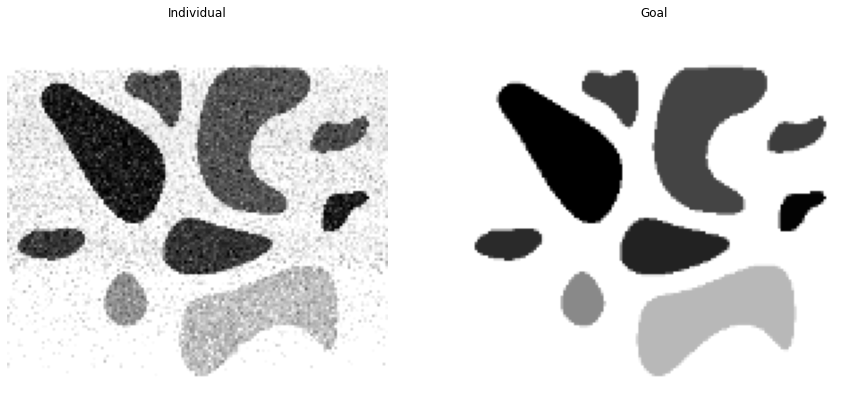

In [64]:
Image('Outputs/g5000000_objetos.png', width=400, height=400)

### Quantitative Analysis


## **Conclusions**

### General Conclusions
As expected, the amount of possibilities makes this a hard problem to solve, especially for higher resolution images. The initial error values can be astronomical, and the optimization can be slow, even if regular.

Still, the results achieved with small images are really similar to the original, even in full resolution, so this project was a success in that front. With really small images, the a very similar result could be achieved in just a few thousand generations. Most of those images, though, reached minimum point after which there was no improvement found, even after hundreds of thousands of generations.

This, along with the noisy result that the larger images returned, lead to the conclusion that the GA is not exactly copying the goal image, but getting "close enough" so that the characteristics of the original image are present, but not clear of noise or sometimes even whole. This inability of removing noise or getting an exact copy of the original image can be seen as a characteristic of GA, with random movements, crossover and mutation. 

To achieve an exact copy of the image, one individual has to at some point go through a perfect crossover+mutation process, where the last different pixel becomes the exact same shade as the original image and no other pixels are changed. Since the method is random, the chances of that happening are very slim.

### Future Work

Future work for this project would be to speed up each iteration so that larger images can be tested in appropriate times, and test different or more exotic methods of reproduction, mutation and others. In this project, the mutation rate (MR) was **static**, so a dynamic MR could lead to different results as well. This project can also be scaled to deal with colored images, especially if the aforementioned problems are solved.